# Analyse du jeu de données DVF - Appartements à Paris

L'objectif est d"analyser les transactions pour les **appartements** situés à **Paris** entre 2017 et 2022:
- Filtres statiques
- Modèles de régression
- Valeurs aberrantes
- Contribution des variables

On commencera par utiliser la base de données DVF. 

**TODO**
- Faire une combinaison trimestre/année (ex: "Q12018")

- **Ajouter les données de la Base Nationale des Bâtiments (exploration, puis modèles)**

- (Ajouter des variables externes (ex: pollution, transports en commun, bdd bâtiments))

- `nombre_pieces_principales` : dummy ou quanti ?

- Tester pipeline avec/sans preprocessing (`StandardScaler()` & `PCA()`)

- `optuna` 
    - optimisation hyperparams
    - utiliser `l_valeur_fonciere` en cible
    - objectif : test MAPE sur `valeur_fonciere`

## Setup

In [1]:
import sys
sys.path.append("../")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from lib.preprocessing import dvf

In [4]:
import pandas as pd 
import numpy as np 
from tqdm import tqdm 
from multiprocessing import cpu_count

import seaborn as sns 
import matplotlib.pyplot as plt 

import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from sklearn.linear_model import (
    LinearRegression, 
    Ridge, 
    Lasso, 
    ElasticNet
) 

from sklearn.dummy import DummyRegressor

from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn.metrics import (
    mean_absolute_error, 
    mean_absolute_percentage_error, 
    r2_score, 
    make_scorer
)
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

import sqlalchemy
from optuna import Trial, create_study

In [5]:
CPU_COUNT = cpu_count()
CPU_COUNT

8

In [6]:
pd.set_option("display.max_columns", None)

In [7]:
DATA_DIR = "../data/"
ZIP_DIR = f"{DATA_DIR}dvf_cleaned.zip" 

## Data

In [8]:
df = dvf.concat_datasets_per_year(ZIP_DIR, geo_area="Paris", property_type="flats")

Processing 2022: 100%|██████████| 6/6 [02:37<00:00, 26.19s/it]


In [9]:
df.tail()

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,ancien_code_commune,ancien_nom_commune,id_parcelle,ancien_id_parcelle,numero_volume,lot1_numero,lot1_surface_carrez,lot2_numero,lot2_surface_carrez,lot3_numero,lot3_surface_carrez,lot4_numero,lot4_surface_carrez,lot5_numero,lot5_surface_carrez,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude,dependance,code_region,nom_departement,nom_region,degre_densite,pop,annee,trimestre,mois,jour
160752,2022-537265,2022-05-17,1,Vente,130000.0,20.0,NaN,RUE PIERRE LEROUX,7451,75007.0,75107,Paris 7e Arrondissement,75,NaN,NaN,75107000BG0031,NaN,NaN,12.0,10.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0,Appartement,11.0,1.0,NaN,NaN,NaN,NaN,NaN,2.319004,48.849079,0,11,Paris,Île-de-France,Paris,52512.0,2022,2,5,17
160753,2022-537266,2022-06-22,1,Vente,330375.0,10.0,NaN,RUE DU CHEVALERET,1990,75013.0,75113,Paris 13e Arrondissement,75,NaN,NaN,75113000CI0017,NaN,NaN,22.0,NaN,37.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,3,2.0,Appartement,40.0,2.0,NaN,NaN,NaN,NaN,NaN,2.378447,48.825798,0,11,Paris,Île-de-France,Paris,181552.0,2022,2,6,22
160754,2022-537267,2022-06-29,1,Vente,2801244.0,3.0,NaN,VLA JOCELYN,4983,75016.0,75116,Paris 16e Arrondissement,75,NaN,NaN,75116000EB0007,NaN,NaN,313.0,183.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0,Appartement,172.0,6.0,NaN,NaN,NaN,NaN,NaN,2.276055,48.865299,1,11,Paris,Île-de-France,Paris,165446.0,2022,2,6,29
160755,2022-537271,2022-06-21,1,Vente,423000.0,43.0,NaN,RUE DES FAVORITES,3536,75015.0,75115,Paris 15e Arrondissement,75,NaN,NaN,75115000AC0055,NaN,NaN,16.0,NaN,48.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2.0,Appartement,43.0,2.0,NaN,NaN,NaN,NaN,NaN,2.305379,48.837454,1,11,Paris,Île-de-France,Paris,233484.0,2022,2,6,21
160756,2022-537272,2022-06-30,1,Vente,104650.0,50.0,NaN,RUE LEON FROT,5554,75011.0,75111,Paris 11e Arrondissement,75,NaN,NaN,75111000BS0234,NaN,NaN,31.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0,Appartement,15.0,1.0,NaN,NaN,NaN,NaN,NaN,2.386354,48.856079,0,11,Paris,Île-de-France,Paris,147017.0,2022,2,6,30


In [10]:
df.shape

(160757, 50)

In [11]:
n_unique_ids = df.id_mutation.unique().shape[0]
assert n_unique_ids == df.shape[0]

print(f"{n_unique_ids} transactions uniques pour les appartements à Paris")

160757 transactions uniques pour les appartements à Paris


### Sélection des variables

In [12]:
VARS = [
    "id_mutation", 
    "date_mutation", 
    "valeur_fonciere",
    "nom_commune",
    "longitude",
    "latitude", 
    "pop", 
    "annee", 
    "trimestre", 
    "mois", 
    "jour", 
    "dependance", 
    "surface_terrain", 
    "surface_reelle_bati", 
    "nombre_pieces_principales" 
]

df2 = df.loc[:, df.columns.isin(VARS)]

In [13]:
df2.shape

(160757, 15)

### Filtres statiques

**Objectif** : éliminer les biens ayant des caractéristiques aberrantes pouvant ajouter du bruit aux données

In [14]:
df2.describe()

,valeur_fonciere,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude,dependance,pop,annee,trimestre,mois,jour
count,1.606820e+05,160756.000000,160756.000000,138.000000,160593.000000,160593.000000,160757.000000,160757.000000,160757.000000,160757.000000,160757.00000,160757.000000
mean,5.774656e+05,53.627877,2.411282,420.840580,2.340310,48.862293,0.278737,146606.664686,2019.485030,2.534154,6.62439,16.565157
std,8.807797e+05,39.868650,1.296799,576.248847,0.037832,0.019980,0.448379,61840.601802,1.526087,1.109350,3.39794,8.881552
min,1.500000e-01,1.000000,0.000000,33.000000,2.255896,48.818759,0.000000,16252.000000,2017.000000,1.000000,1.00000,1.000000
25%,2.550000e+05,28.000000,1.000000,144.250000,2.310880,48.845756,0.000000,91932.000000,2018.000000,2.000000,4.00000,9.000000
50%,4.100000e+05,43.000000,2.000000,210.500000,2.343348,48.862767,0.000000,165446.000000,2019.000000,3.000000,7.00000,17.000000
75%,6.775000e+05,68.000000,3.000000,453.250000,2.371079,48.879998,1.000000,195060.000000,2021.000000,4.000000,10.00000,25.000000
max,1.315000e+08,1500.000000,26.000000,4006.000000,2.412825,48.900565,1.000000,233484.000000,2022.000000,4.000000,12.00000,31.000000


#### Nombre de pièces principales

Suppression des biens de + de 8 pièces principales et des biens ayant aucune pièce principale. 

In [15]:
df2.nombre_pieces_principales.value_counts()

2.0     54848
1.0     42061
3.0     36110
4.0     16434
5.0      7127
6.0      2551
7.0       969
8.0       299
0.0       196
9.0        75
10.0       47
11.0       17
12.0        6
13.0        3
17.0        2
16.0        2
20.0        2
22.0        1
21.0        1
19.0        1
23.0        1
26.0        1
14.0        1
15.0        1
Name: nombre_pieces_principales, dtype: int64

In [16]:
df2 = df2.loc[
    (df2.nombre_pieces_principales > 0) &
    (df2.nombre_pieces_principales <= 8),
    :
]

def encode_num_rooms(n: int) -> str: 
    """Description. Group properties with 6+ rooms into '6-8' category."""
    if n < 6: 
        return str(n)
    else: 
        return "6-8"

# convert to integer
df2["nombre_pieces_principales"] = df2["nombre_pieces_principales"].apply(encode_num_rooms)

In [17]:
df2.nombre_pieces_principales.value_counts()

2.0    54848
1.0    42061
3.0    36110
4.0    16434
5.0     7127
6-8     3819
Name: nombre_pieces_principales, dtype: int64

In [18]:
df2.describe()

,valeur_fonciere,surface_reelle_bati,surface_terrain,longitude,latitude,dependance,pop,annee,trimestre,mois,jour
count,1.603240e+05,160399.000000,137.000000,160235.000000,160235.000000,160399.000000,160399.000000,160399.000000,160399.000000,160399.000000,160399.000000
mean,5.748149e+05,53.446156,419.934307,2.340339,48.862293,0.278674,146643.630484,2019.485203,2.534049,6.624243,16.564143
std,8.695325e+05,38.901960,578.264813,0.037830,0.019987,0.448348,61834.452756,1.526081,1.109335,3.397842,8.881882
min,1.500000e-01,1.000000,33.000000,2.255896,48.818759,0.000000,16252.000000,2017.000000,1.000000,1.000000,1.000000
25%,2.550000e+05,28.000000,144.000000,2.310966,48.845753,0.000000,91932.000000,2018.000000,2.000000,4.000000,9.000000
50%,4.100000e+05,43.000000,210.000000,2.343348,48.862766,0.000000,165446.000000,2019.000000,3.000000,7.000000,17.000000
75%,6.769000e+05,68.000000,442.000000,2.371096,48.880005,1.000000,195060.000000,2021.000000,4.000000,10.000000,25.000000
max,1.315000e+08,650.000000,4006.000000,2.412825,48.900565,1.000000,233484.000000,2022.000000,4.000000,12.000000,31.000000


In [19]:
df2.loc[df2.nombre_pieces_principales == "6-8",: ].describe()

,valeur_fonciere,surface_reelle_bati,surface_terrain,longitude,latitude,dependance,pop,annee,trimestre,mois,jour
count,3.818000e+03,3819.000000,9.000000,3819.000000,3819.000000,3819.000000,3819.000000,3819.000000,3819.000000,3819.000000,3819.000000
mean,2.210862e+06,187.706730,222.888889,2.310559,48.863778,0.540194,122775.075674,2019.507463,2.568473,6.732129,17.009427
std,1.520705e+06,58.435988,296.795150,0.031662,0.014603,0.498447,63198.709242,1.529570,1.106536,3.374673,8.847904
min,1.000000e+00,8.000000,33.000000,2.255896,48.820082,0.000000,16252.000000,2017.000000,1.000000,1.000000,1.000000
25%,1.448500e+06,147.000000,88.000000,2.284334,48.853251,0.000000,52512.000000,2018.000000,2.000000,4.000000,10.000000
50%,2.020000e+06,178.000000,135.000000,2.304319,48.864034,1.000000,165446.000000,2019.000000,3.000000,7.000000,17.000000
75%,2.739650e+06,218.000000,187.000000,2.330949,48.876606,1.000000,165446.000000,2021.000000,4.000000,10.000000,25.000000
max,2.150000e+07,650.000000,992.000000,2.407545,48.897606,1.000000,233484.000000,2022.000000,4.000000,12.000000,31.000000


#### Surface du bien

Au regard des graphiques suivants, il semble pertinent de garder les biens ayant une surface comprise entre 9m² et 250m².

D'après la [loi](https://www.service-public.fr/particuliers/vosdroits/F35977/1?idFicheParent=F34905#1), *un logement mis en location doit respecter une surface minimum. Il s'agit d'un des critères de décence du logement. Le logement doit comporter au moins une pièce principale ayant :*
- *Soit une surface habitable d'au moins 9 m² et une hauteur sous plafond d'au moins 2,20 m* 
- *Soit un volume habitable d'au moins 20m $^3$*

In [20]:
df2.surface_reelle_bati.describe()

count    160399.000000
mean         53.446156
std          38.901960
min           1.000000
25%          28.000000
50%          43.000000
75%          68.000000
max         650.000000
Name: surface_reelle_bati, dtype: float64

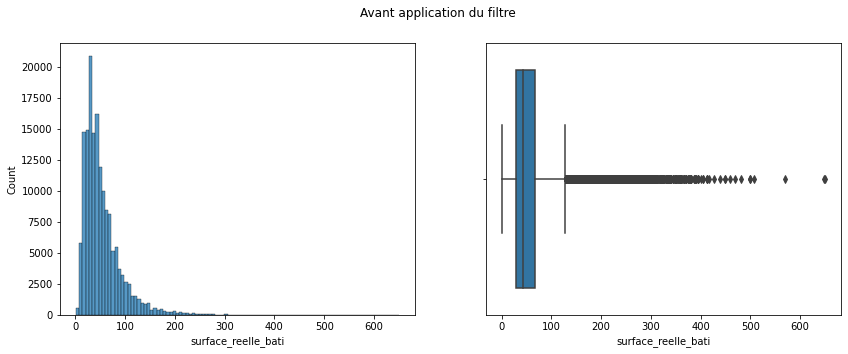

In [21]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
fig.suptitle("Avant application du filtre")

sns.histplot(data=df2, x="surface_reelle_bati", bins=100, ax=axes[0])
sns.boxplot(data=df2, x="surface_reelle_bati", ax=axes[1]);  

In [22]:
df2 = df2.loc[
    (df2.surface_reelle_bati >= 9) & 
    (df2.surface_reelle_bati <= 250), 
    :
]

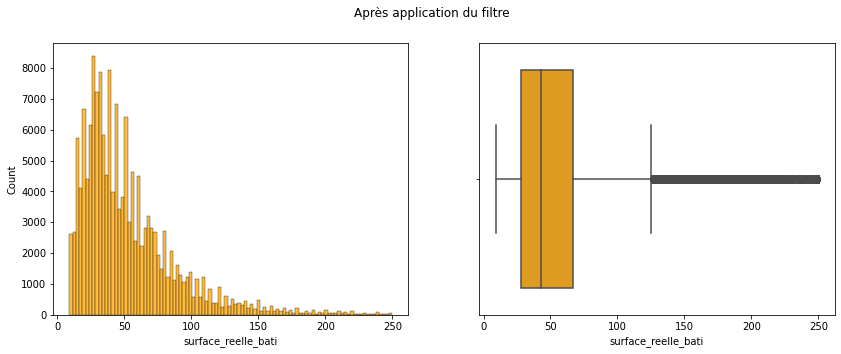

In [23]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
fig.suptitle("Après application du filtre")

sns.histplot(data=df2, x="surface_reelle_bati", color="orange", bins=100, ax=axes[0])
sns.boxplot(data=df2, x="surface_reelle_bati", color="orange", ax=axes[1]);  

In [24]:
df2.describe()

,valeur_fonciere,surface_reelle_bati,surface_terrain,longitude,latitude,dependance,pop,annee,trimestre,mois,jour
count,1.587560e+05,158831.000000,136.000000,158667.000000,158667.000000,158831.000000,158831.000000,158831.000000,158831.000000,158831.000000,158831.000000
mean,5.664912e+05,52.892105,422.352941,2.340493,48.862257,0.278541,146896.483451,2019.484868,2.533636,6.622775,16.565759
std,8.382248e+05,36.019477,579.706650,0.037816,0.020026,0.448283,61785.247762,1.526210,1.109301,3.397678,8.881372
min,1.500000e-01,9.000000,33.000000,2.255896,48.818759,0.000000,16252.000000,2017.000000,1.000000,1.000000,1.000000
25%,2.575000e+05,28.000000,144.750000,2.311355,48.845670,0.000000,91932.000000,2018.000000,2.000000,4.000000,9.000000
50%,4.122500e+05,43.000000,210.500000,2.343432,48.862673,0.000000,165446.000000,2019.000000,3.000000,7.000000,17.000000
75%,6.750000e+05,67.000000,445.750000,2.371308,48.880036,1.000000,195060.000000,2021.000000,4.000000,10.000000,25.000000
max,1.315000e+08,250.000000,4006.000000,2.412825,48.900565,1.000000,233484.000000,2022.000000,4.000000,12.000000,31.000000


In [25]:
df2.loc[df2.surface_reelle_bati==250, :].describe()

,valeur_fonciere,surface_reelle_bati,surface_terrain,longitude,latitude,dependance,pop,annee,trimestre,mois,jour
count,4.000000e+01,40.0,0.0,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.00000,40.000000
mean,3.282032e+06,250.0,NaN,2.301378,48.869575,0.525000,130038.500000,2019.375000,2.600000,6.87500,18.650000
std,1.902103e+06,0.0,NaN,0.021505,0.011070,0.505736,59974.673545,1.371645,1.236206,3.63168,8.368286
min,5.000000e+04,250.0,NaN,2.266537,48.846405,0.000000,16252.000000,2017.000000,1.000000,1.00000,1.000000
25%,2.549575e+06,250.0,NaN,2.285491,48.860895,0.000000,52512.000000,2018.000000,1.000000,3.00000,13.500000
50%,2.890842e+06,250.0,NaN,2.299666,48.867970,1.000000,165446.000000,2019.000000,3.000000,7.00000,19.500000
75%,3.672500e+06,250.0,NaN,2.309531,48.880958,1.000000,167835.000000,2020.250000,4.000000,10.00000,25.250000
max,9.202514e+06,250.0,NaN,2.359277,48.886915,1.000000,195060.000000,2022.000000,4.000000,12.00000,30.000000


#### Surface terrain

On commence par mettre à 0 les valeurs manquantes dans la colonne `surface_terrain`. 

In [26]:
def encode_field_area(area: float) -> float: 

    if pd.isna(area): 
        area = 0
    return area 

assert encode_field_area(float("nan")) == 0
assert encode_field_area(102.) == 102.
 
df2["surface_terrain"] = df2["surface_terrain"].apply(encode_field_area) 

In [27]:
df2["surface_terrain"].describe()

count    158831.000000
mean          0.361642
std          20.934422
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        4006.000000
Name: surface_terrain, dtype: float64

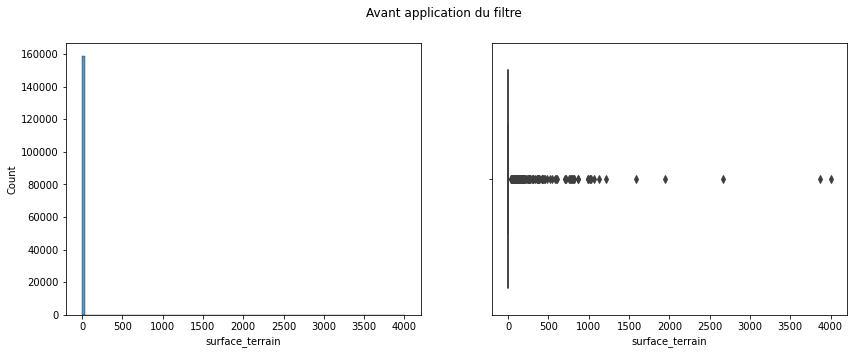

In [28]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
fig.suptitle("Avant application du filtre")

sns.histplot(data=df2, x="surface_terrain", bins=100, ax=axes[0])
sns.boxplot(data=df2, x="surface_terrain", ax=axes[1]);  

In [29]:
df2.loc[df2.surface_terrain == 0].shape[0] / df2.shape[0]

0.9991437439794498

La surface du terrain est nulle pour la majorité des biens (99.91%), ce qui fait sens puisque ce sont des appartements à Paris. On décide donc de supprimer cette variable du jeu de données utilisé pour la modélisation. 

### Variable cible : `valeur_fonciere`

In [30]:
df2["valeur_fonciere"].describe()

count    1.587560e+05
mean     5.664912e+05
std      8.382248e+05
min      1.500000e-01
25%      2.575000e+05
50%      4.122500e+05
75%      6.750000e+05
max      1.315000e+08
Name: valeur_fonciere, dtype: float64

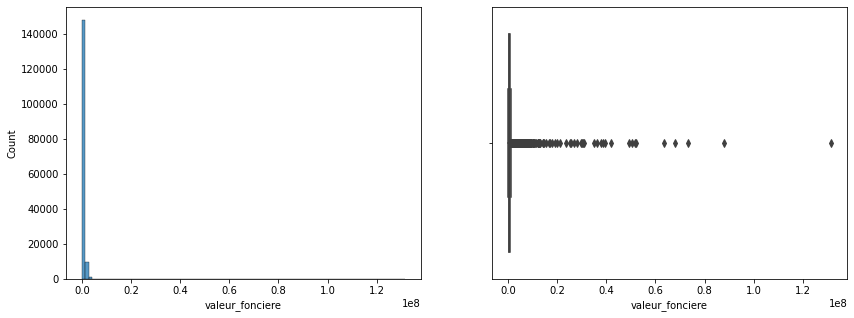

In [31]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))

sns.histplot(data=df2, x="valeur_fonciere", bins=100, ax=axes[0])
sns.boxplot(data=df2, x="valeur_fonciere", ax=axes[1]);  

On décide de transfomer la variable `valeur_fonciere` en divisant par la surface du bien (en m²). On obtient la variable `valeur_fonciere_m2`: 

$$
\text{valeur\_fonciere\_m2} = \frac{\text{valeur\_fonciere}}{\text{surface\_reelle\_bati}}
$$

On choisit aussi d'appliquer le logarithme aux variables `valeur_fonciere` et `valeur_fonciere_m2`: 

$$
\begin{aligned}
\text{l\_valeur\_fonciere\_m2} & = \log (\text{valeur\_fonciere\_m2}) \\
\text{l\_valeur\_fonciere} & = \log (\text{valeur\_fonciere})
\end{aligned}
$$


In [32]:
from typing import Optional

def transform_target_variable(price: float, log:bool, area: Optional[float]=None) -> float: 

    y = price

    if area != None: 
        y = y / area

    if log: 
        y = np.log(y)
    
    return y 

df2["valeur_fonciere_m2"] = df2.apply(lambda row: transform_target_variable(row.valeur_fonciere, False, row.surface_reelle_bati), axis=1) 
df2["l_valeur_fonciere_m2"] = df2.apply(lambda row: transform_target_variable(row.valeur_fonciere_m2, True), axis=1) 
df2["l_valeur_fonciere"] = df2.apply(lambda row: transform_target_variable(row.valeur_fonciere, True), axis=1) 

In [33]:
for target in ("valeur_fonciere_m2", "l_valeur_fonciere", "l_valeur_fonciere_m2"): 
    display(df2[target].describe())

count    1.587560e+05
mean     1.060239e+04
std      1.606198e+04
min      3.750000e-03
25%      8.552632e+03
50%      1.018519e+04
75%      1.191764e+04
max      2.155738e+06
Name: valeur_fonciere_m2, dtype: float64

count    158756.000000
mean         12.851179
std           1.144807
min          -1.897120
25%          12.458775
50%          12.929385
75%          13.422468
max          18.694517
Name: l_valeur_fonciere, dtype: float64

count    158756.000000
mean          9.082756
std           0.966271
min          -5.585999
25%           9.053994
50%           9.228690
75%           9.385775
max          14.583644
Name: l_valeur_fonciere_m2, dtype: float64

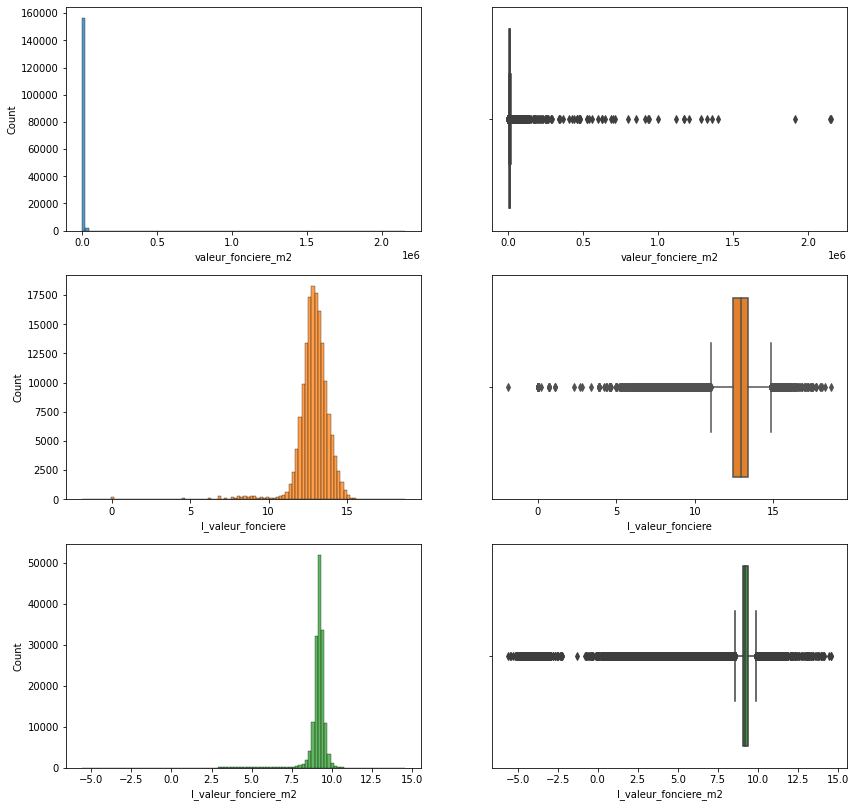

In [34]:
colors = sns.color_palette(n_colors=3)
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(14, 14))

for ix, target in enumerate(["valeur_fonciere_m2", "l_valeur_fonciere", "l_valeur_fonciere_m2"]): 

    sns.histplot(data=df2, x=target, bins=100, ax=axes[ix, 0], color=colors[ix])
    sns.boxplot(data=df2, x=target, ax=axes[ix, 1], color=colors[ix]); 

D'après l'estimation faite par [meilleursagents](https://www.meilleursagents.com/prix-immobilier/paris-75000/), le prix/m² des appartements à Paris peut valoir entre de 6 847 € à 16 324 €. Afin d'être moins restrictif et pour prendre en compte les éventuelles fluctuations, on décide de sélectionner les biens tq $\text{valeur\_fonciere\_m2} \in [5 000, 20 000]$.

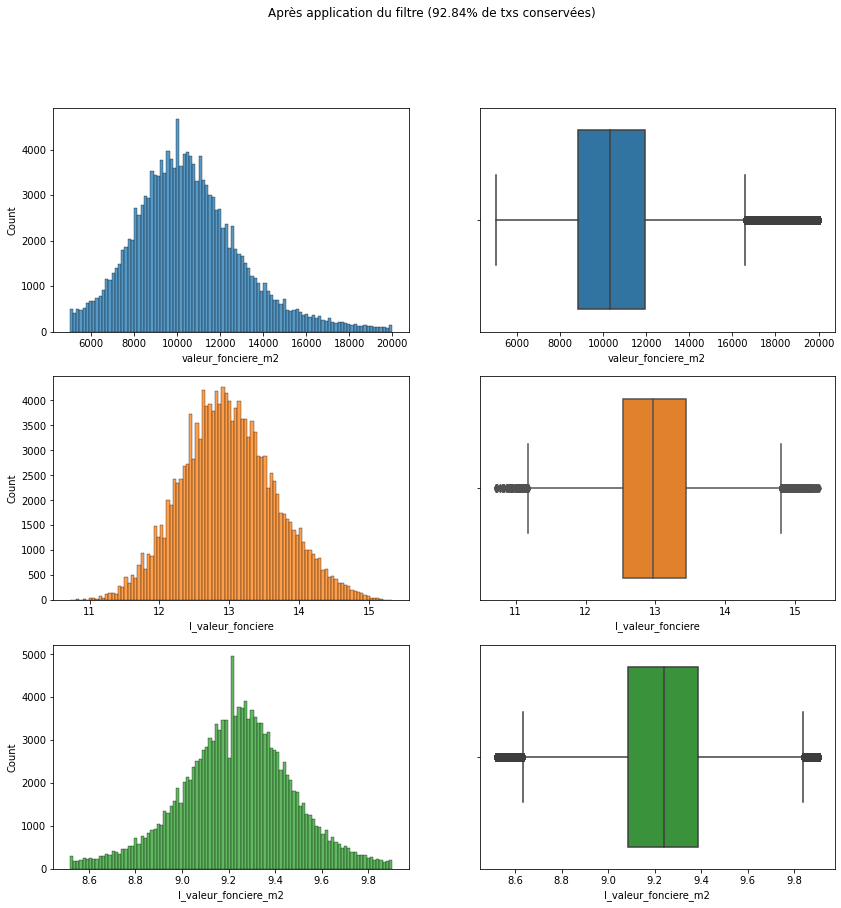

In [35]:
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(14, 14))

tmp = df2.loc[
    (df2.valeur_fonciere_m2 >= 5000) & 
    (df2.valeur_fonciere_m2 <= 20000), 
    :
]
prop = tmp.shape[0] / df2.shape[0]

fig.suptitle(f"Après application du filtre ({round(100 *prop, 2)}% de txs conservées)")

for ix, target in enumerate(["valeur_fonciere_m2", "l_valeur_fonciere", "l_valeur_fonciere_m2"]): 

    sns.histplot(data=tmp, x=target, bins=100, ax=axes[ix, 0], color=colors[ix])
    sns.boxplot(data=tmp, x=target, ax=axes[ix, 1], color=colors[ix])

del tmp; 

In [36]:
df2 = df2.loc[
    (df2.valeur_fonciere_m2 >= 5000) & 
    (df2.valeur_fonciere_m2 <= 20000), 
    :
]

### Ajout de la variable `arrondissement`

On isole les arrondissements à partir de la variable `nom_commune`. 

In [37]:
DIGIT = r"[0-9]+"
import re

def extract_int_from_string(string: str) -> int: 
    integer = re.findall(DIGIT, string)

    if len(integer) > 1: 
        raise ValueError("Multiple integers found.")
    return integer[0]

In [38]:
df2["arrondissement"] = df2.nom_commune.apply(extract_int_from_string)

In [39]:
df2.arrondissement.value_counts() / df2.shape[0]

18    0.109866
15    0.108551
17    0.088327
16    0.086198
11    0.083458
20    0.067161
19    0.055889
12    0.054133
14    0.051915
10    0.051888
13    0.048538
9     0.037483
7     0.025995
5     0.025900
6     0.022068
3     0.021315
8     0.020122
2     0.016168
4     0.015585
1     0.009440
Name: arrondissement, dtype: float64

### Variables temporelles

On décide de construire la variable `trimestre_annee` qui est la concaténation des variables `trimestre` et `annee`. 

In [40]:
df2.trimestre

0         3
1         3
2         3
3         3
4         3
         ..
160752    2
160753    2
160754    2
160755    2
160756    2
Name: trimestre, Length: 147452, dtype: int64

In [41]:
def get_quarter_year(quarter: int, year: int) -> str: 
    return f"{year}Q{quarter}"

df2["trimestre_annee"] = df2.apply(lambda row: get_quarter_year(row.trimestre, row.annee), axis=1)

### Encodage du type des variables

In [42]:
CAT_VARS = [
    "nombre_pieces_principales", 
    "dependance", 
    "arrondissement", 
    "trimestre_annee" 
]

QUANT_VARS = [
    "valeur_fonciere", 
    "valeur_fonciere_m2", 
    "l_valeur_fonciere", 
    "l_valeur_fonciere_m2", 
    "surface_reelle_bati", 
]

ID_VARS = ["id_mutation", "date_mutation"]

df3 = df2.loc[:, ID_VARS+QUANT_VARS+CAT_VARS]

df3.loc[:, CAT_VARS] = df2.loc[:, CAT_VARS].astype(object)
df3.loc[:, QUANT_VARS] = df3.loc[:, QUANT_VARS].astype(float)

In [43]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147452 entries, 0 to 160756
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   id_mutation                147452 non-null  object        
 1   date_mutation              147452 non-null  datetime64[ns]
 2   valeur_fonciere            147452 non-null  float64       
 3   valeur_fonciere_m2         147452 non-null  float64       
 4   l_valeur_fonciere          147452 non-null  float64       
 5   l_valeur_fonciere_m2       147452 non-null  float64       
 6   surface_reelle_bati        147452 non-null  float64       
 7   nombre_pieces_principales  147452 non-null  object        
 8   dependance                 147452 non-null  object        
 9   arrondissement             147452 non-null  object        
 10  trimestre_annee            147452 non-null  object        
dtypes: datetime64[ns](1), float64(5), object(5)
memory u

### Croisement entre variables

In [44]:
df3[QUANT_VARS]\
    .corr(method="pearson")\
    [["valeur_fonciere_m2", "l_valeur_fonciere", "l_valeur_fonciere_m2"]]

,valeur_fonciere_m2,l_valeur_fonciere,l_valeur_fonciere_m2
valeur_fonciere,0.417387,0.897513,0.402363
valeur_fonciere_m2,1.000000,0.408717,0.984420
l_valeur_fonciere,0.408717,1.000000,0.414662
l_valeur_fonciere_m2,0.984420,0.414662,1.000000
surface_reelle_bati,0.122096,0.881760,0.117010


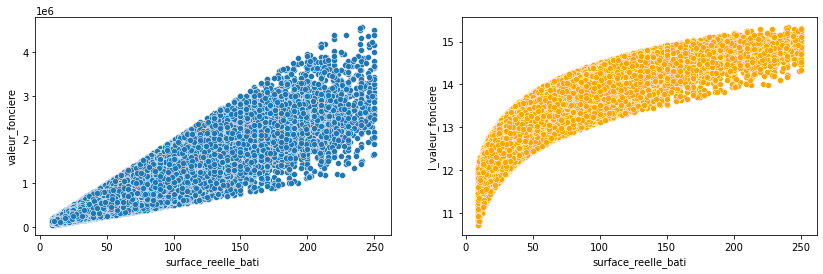

In [45]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4))

sns.scatterplot(data=df3, x="surface_reelle_bati", y="valeur_fonciere", ax=axes[0])
sns.scatterplot(data=df3, x="surface_reelle_bati", y="l_valeur_fonciere", color="orange", ax=axes[1]); 

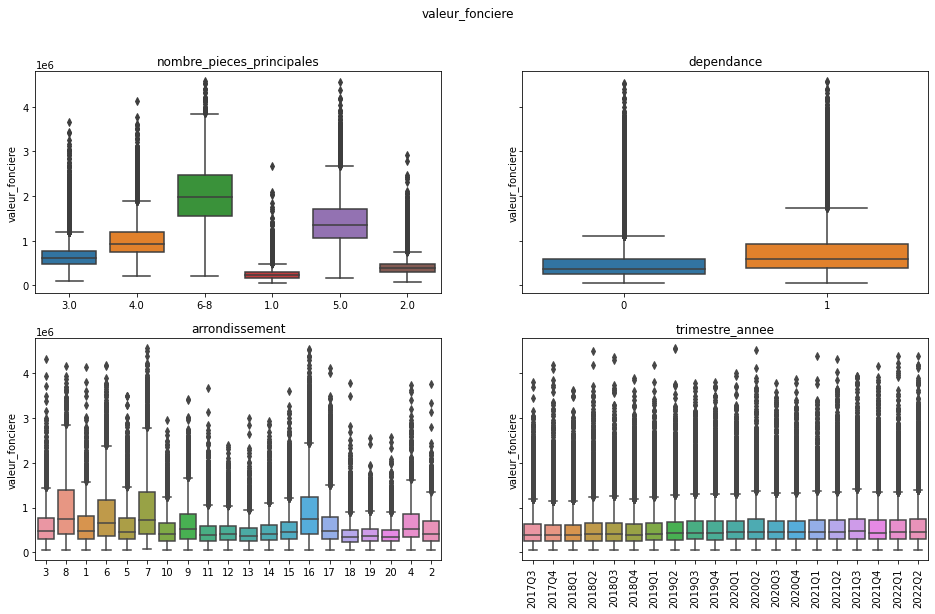

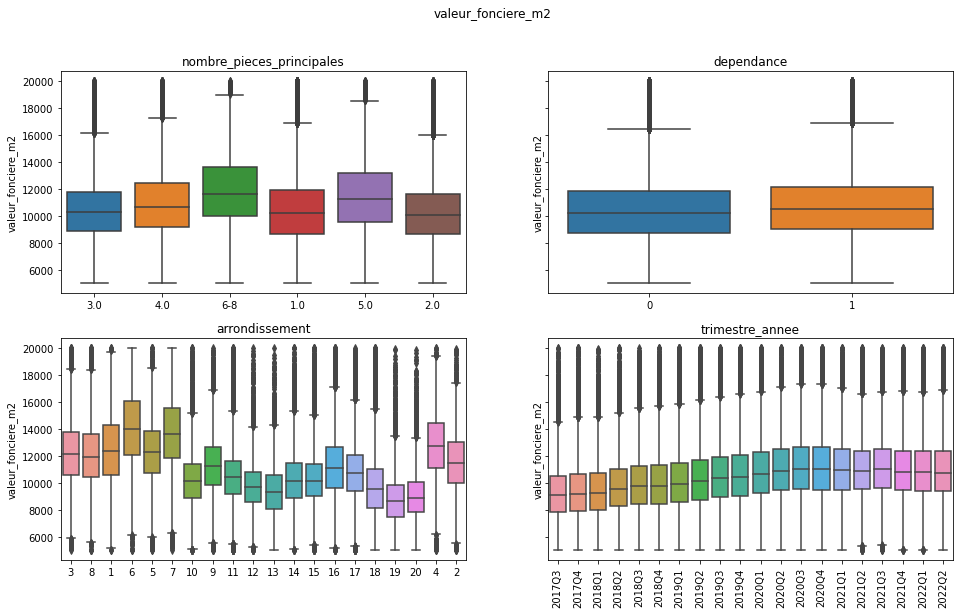

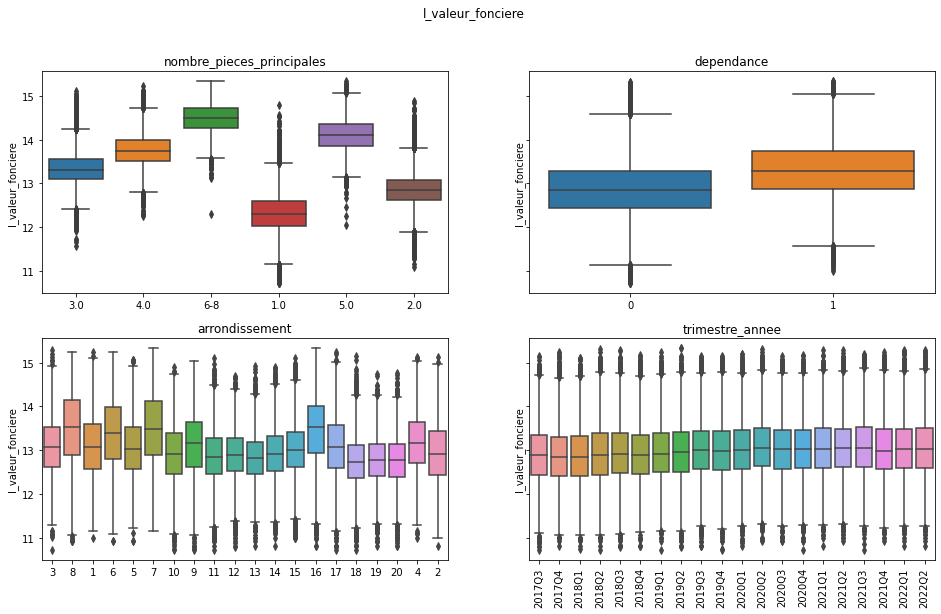

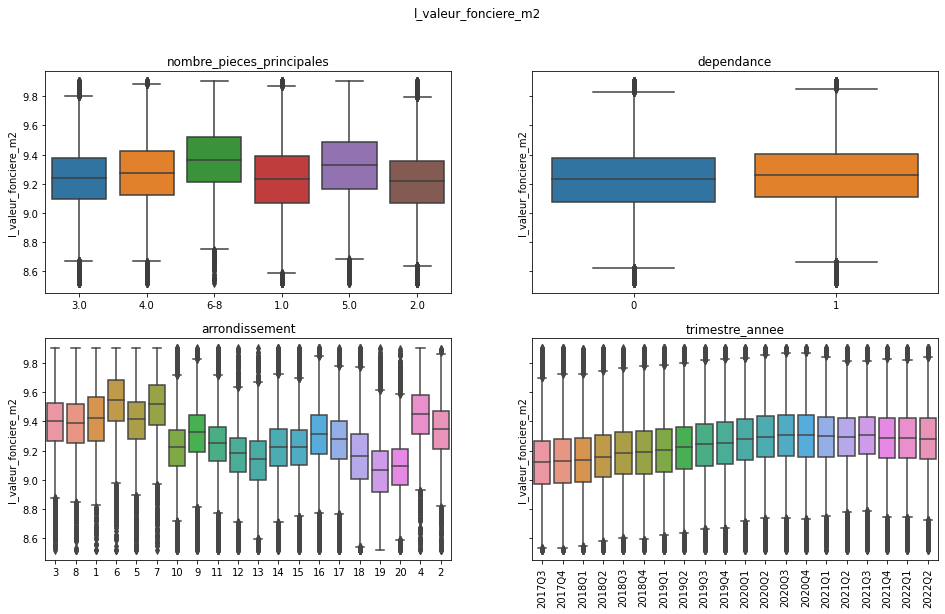

In [46]:
for target in ("valeur_fonciere", "valeur_fonciere_m2", "l_valeur_fonciere", "l_valeur_fonciere_m2"): 

    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(16, 9), sharey=True)
    fig.suptitle(target)

    for var, ax in zip(CAT_VARS, axes.flatten()):
        sns.boxplot(data=df3, x=var, y=target, ax=ax)

        if var == "trimestre_annee": 
            ax.tick_params(axis="x", rotation=90)

        ax.set_title(var)
        ax.set_xlabel(""); 

C:\Users\pemma\AppData\Local\Temp/ipykernel_17268/935798534.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  price_evol = df3\


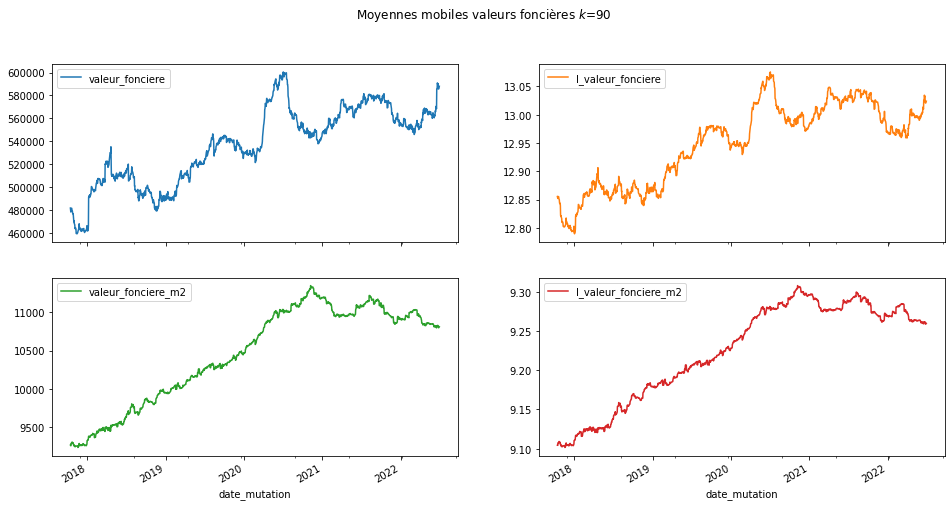

In [68]:
price_evol = df3\
    .groupby(["date_mutation"])\
    ["valeur_fonciere", "l_valeur_fonciere", "valeur_fonciere_m2", "l_valeur_fonciere_m2"]\
    .mean() 

k = 90

price_evol\
    .rolling(window=k)\
    .mean()\
    .plot(
        subplots=True, 
        layout=(2, 2), 
        figsize=(16, 8), 
        title=rf"Moyennes mobiles valeurs foncières $k$={k}");

### Sélection des variables discriminantes

Au vu des graphiques précédents, on sélectionne uniquement les variables dummies liés aux nombre de pièces, arrondissements, trimestres et années ainsi que la dummy `dependance`. La seule variable quantitative intéressante est `surface_relle_bati`. 

In [74]:
# drop identifying variables

df_mod = df3.drop(labels=["id_mutation", "date_mutation"], axis=1)

Index(['valeur_fonciere', 'valeur_fonciere_m2', 'l_valeur_fonciere',
       'l_valeur_fonciere_m2', 'surface_reelle_bati',
       'nombre_pieces_principales', 'dependance', 'arrondissement',
       'trimestre_annee'],
      dtype='object')

### Transformation des variables catégorielles

On transforme chaque variable catégorielle $\mathrm{x}_{cat, k}$, contenant $n_k$ niveaux, en $n_k-1$ variables indicatrices. 

Les variables considérées sont : 
- `nombre_pieces_princicpales`
- `dependance`
- `trimestre_annee`
- `arrondissement`

On peut utiliser la fonction `pd.get_dummies()` pour transformer les variables catégorielles.

In [75]:
df_mod = pd.get_dummies(data=df_mod, drop_first=False)

In [76]:
df_mod.head()

,valeur_fonciere,valeur_fonciere_m2,l_valeur_fonciere,l_valeur_fonciere_m2,surface_reelle_bati,nombre_pieces_principales_1.0,nombre_pieces_principales_2.0,nombre_pieces_principales_3.0,nombre_pieces_principales_4.0,nombre_pieces_principales_5.0,nombre_pieces_principales_6-8,dependance_0,dependance_1,arrondissement_1,arrondissement_10,arrondissement_11,arrondissement_12,arrondissement_13,arrondissement_14,arrondissement_15,arrondissement_16,arrondissement_17,arrondissement_18,arrondissement_19,arrondissement_2,arrondissement_20,arrondissement_3,arrondissement_4,arrondissement_5,arrondissement_6,arrondissement_7,arrondissement_8,arrondissement_9,trimestre_annee_2017Q3,trimestre_annee_2017Q4,trimestre_annee_2018Q1,trimestre_annee_2018Q2,trimestre_annee_2018Q3,trimestre_annee_2018Q4,trimestre_annee_2019Q1,trimestre_annee_2019Q2,trimestre_annee_2019Q3,trimestre_annee_2019Q4,trimestre_annee_2020Q1,trimestre_annee_2020Q2,trimestre_annee_2020Q3,trimestre_annee_2020Q4,trimestre_annee_2021Q1,trimestre_annee_2021Q2,trimestre_annee_2021Q3,trimestre_annee_2021Q4,trimestre_annee_2022Q1,trimestre_annee_2022Q2
0,571110.0,13597.857143,13.255337,9.517667,42.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1578150.0,11690.000000,14.271764,9.366489,135.0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2810880.0,12776.727273,14.849008,9.455381,220.0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,130000.0,9285.714286,11.775290,9.136232,14.0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,485000.0,12763.157895,13.091904,9.454318,38.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [77]:
list(df_mod.columns)

['valeur_fonciere',
 'valeur_fonciere_m2',
 'l_valeur_fonciere',
 'l_valeur_fonciere_m2',
 'surface_reelle_bati',
 'nombre_pieces_principales_1.0',
 'nombre_pieces_principales_2.0',
 'nombre_pieces_principales_3.0',
 'nombre_pieces_principales_4.0',
 'nombre_pieces_principales_5.0',
 'nombre_pieces_principales_6-8',
 'dependance_0',
 'dependance_1',
 'arrondissement_1',
 'arrondissement_10',
 'arrondissement_11',
 'arrondissement_12',
 'arrondissement_13',
 'arrondissement_14',
 'arrondissement_15',
 'arrondissement_16',
 'arrondissement_17',
 'arrondissement_18',
 'arrondissement_19',
 'arrondissement_2',
 'arrondissement_20',
 'arrondissement_3',
 'arrondissement_4',
 'arrondissement_5',
 'arrondissement_6',
 'arrondissement_7',
 'arrondissement_8',
 'arrondissement_9',
 'trimestre_annee_2017Q3',
 'trimestre_annee_2017Q4',
 'trimestre_annee_2018Q1',
 'trimestre_annee_2018Q2',
 'trimestre_annee_2018Q3',
 'trimestre_annee_2018Q4',
 'trimestre_annee_2019Q1',
 'trimestre_annee_2019Q2',
 

### Suppression des valeurs manquantes

On supprime les lignes ayant au moins une valeur manquante. Des méthodes d"imputation pourraient être envisagées par la suite. 

In [48]:
df_mod = df_mod.dropna()

In [49]:
n, p = df_mod.shape
print(f"{p} variables et {n} observations")

33 variables et 148167 observations


### Train/test split

On divise le jeu de données en 2: 
- 80% de données d"entrainement
- 20% de données test

In [50]:
targets = ["valeur_fonciere", "l_valeur_fonciere", "l_valeur_fonciere_m2"]

n= df_mod.shape[0]
train_prop = .8
train_size = int(train_prop*n)
train_idxs = np.random.randint(low=0, high=n, size=train_size)

df_train = df_mod.loc[df_mod.index.isin(train_idxs), :]
df_test = df_mod.loc[~df_mod.index.isin(train_idxs), :]

ds = {
    "df_tr": df_train, 
    "df_te": df_test
}

for target in targets:
    if target == "l_valeur_fonciere_m2": 
        to_remove = targets + ["surface_reelle_bati"]
    else: 
        to_remove = targets

    ds[target] = {
        "X_tr": df_train.drop(labels=to_remove, axis=1), 
        "y_tr": df_train[target], 
        "X_te": df_test.drop(labels=to_remove, axis=1),
        "y_te": df_test[target]
    }

In [51]:
# keep areas and unscaled prices for train and test samples
train_areas = ds["df_tr"]["surface_reelle_bati"]
test_areas = ds["df_te"]["surface_reelle_bati"]

train_prices = ds["df_tr"]["valeur_fonciere"]
test_prices = ds["df_te"]["valeur_fonciere"]

In [52]:
def unscale_prediction(y: float, area: float) -> float: 
    """Description. Unscale transformed target variable."""

    return area * np.exp(y)

## Modèles de régression

Un modèle par variable cible : `valeur_fonciere`, `l_valeur_fonciere` et `l_valeur_fonciere_m2`. 

### Approche `statsmodels`

Cette approche a un objectif exploratoire afin de mieux comprendre à quel point la variable $X$ a un impact sur la variable $y$. 

In [58]:
ols_results = {}

for target in targets: 
    X_tr, y_tr = ds[target]["X_tr"], ds[target]["y_tr"]
    X_te, y_te = ds[target]["X_te"], ds[target]["y_te"]

    X_tr = sm.add_constant(X_tr, prepend=False)
    X_te = sm.add_constant(X_te, prepend=False)

    mod = sm.OLS(y_tr, X_tr)
    res = mod.fit()

    y_fitted = res.predict(X_tr)
    y_pred = res.predict(X_te)

    mape_tr = mean_absolute_percentage_error(y_tr.values, y_fitted.values)
    mape_te = mean_absolute_percentage_error(y_te.values, y_pred.values)

    r2_tr = r2_score(y_tr.values, y_fitted.values)
    r2_te = r2_score(y_te.values, y_pred.values)

    ols_results[target] = {
        "ols": res, 
        "mape_tr": mape_tr, 
        "mape_te": mape_te, 
        "r2_tr": r2_tr, 
        "r2_te": r2_te
    }

In [59]:
print(ols_results["valeur_fonciere"]["ols"].summary())

                            OLS Regression Results                            
Dep. Variable:        valeur_fonciere   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                 1.342e+04
Date:                Tue, 14 Mar 2023   Prob (F-statistic):               0.00
Time:                        16:26:15   Log-Likelihood:            -1.0020e+06
No. Observations:               75305   AIC:                         2.004e+06
Df Residuals:                   75274   BIC:                         2.004e+06
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
surface_reelle_bati   

In [60]:
print(ols_results["l_valeur_fonciere"]["ols"].summary())

                            OLS Regression Results                            
Dep. Variable:      l_valeur_fonciere   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     9743.
Date:                Tue, 14 Mar 2023   Prob (F-statistic):               0.00
Time:                        16:26:16   Log-Likelihood:                -16638.
No. Observations:               75305   AIC:                         3.334e+04
Df Residuals:                   75274   BIC:                         3.362e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
surface_reelle_bati   

In [61]:
print(ols_results["l_valeur_fonciere_m2"]["ols"].summary())

                             OLS Regression Results                             
Dep. Variable:     l_valeur_fonciere_m2   R-squared:                       0.223
Model:                              OLS   Adj. R-squared:                  0.223
Method:                   Least Squares   F-statistic:                     745.7
Date:                  Tue, 14 Mar 2023   Prob (F-statistic):               0.00
Time:                          16:26:17   Log-Likelihood:                -479.28
No. Observations:                 75305   AIC:                             1019.
Df Residuals:                     75275   BIC:                             1295.
Df Model:                            29                                         
Covariance Type:              nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
no

In [62]:
for target in targets:
    mape_tr = round(100*ols_results[target]['mape_tr'], 2)
    mape_te = round(100*ols_results[target]['mape_te'], 2)

    r2_tr = round(100*ols_results[target]['r2_tr'], 2)
    r2_te = round(100*ols_results[target]['r2_tr'], 2)

    print(f"{target} - MAPE train={mape_tr}% ; MAPE test={mape_te}% ; R² train={r2_tr}% ; R² test={r2_te}%")

valeur_fonciere - MAPE train=22.6% ; MAPE test=22.28% ; R² train=84.25% ; R² test=84.25%
l_valeur_fonciere - MAPE train=1.76% ; MAPE test=1.73% ; R² train=79.52% ; R² test=79.52%
l_valeur_fonciere_m2 - MAPE train=1.9% ; MAPE test=1.88% ; R² train=22.32% ; R² test=22.32%


### Approche `sklearn`

On commencer par entrainer plusieurs régresseurs sans optimiser les hyperparamètres. L'objectif est d'avoir un aperçu des types de régresseurs qui permettent d'obtenir les meilleurs scores à savoir MAPE et R². 

In [99]:
from sklearn.base import BaseEstimator
from typing import Dict, Optional

class CustomRegressor(BaseEstimator):
    """Description. A Custom BaseEstimator that can switch between regressors.""" 

    def __init__(self, estimator=LinearRegression()):
        self.estimator = estimator

    def fit(self, X: np.ndarray, y: Optional[np.ndarray]=None, **kwargs: Dict):
        self.estimator.fit(X, y)
        return self

    def predict(self, X: np.ndarray, y: Optional[np.ndarray]=None) -> np.ndarray:
        return self.estimator.predict(X) 

    def score(self, X: np.ndarray, y: np.ndarray, scoring: str="r2") -> float:
        if scoring == "r2": 
            return self.estimator.score(X, y)
        elif scoring == "mae": 
            y_pred = self.predict(X)
            return mean_absolute_error(y, y_pred)
        elif scoring == "mape":
            y_pred = self.predict(X)
            return mean_absolute_percentage_error(y, y_pred)
        else: 
            return NotImplementedError

In [ ]:
from rich.table import Table
from rich.console import Console

from typing import List

def display_results_table(results: Dict, target: str) -> Table: 

    title = f"Résultats pour {target}"
    table = Table(title=title)

    table.add_column("Model")
    table.add_column("% MAPE train")
    table.add_column("% MAPE test")
    table.add_column("% R² train")
    table.add_column("% R² test")

    results = results[target]

    for record in results: 
        model, mape_tr, mape_te, r2_tr, r2_te = list(record.values())
        table.add_row(
            model.estimator.__class__.__name__, 
            str(round(100*mape_tr, 2)), 
            str(round(100*mape_te, 2)),
            str(round(100*r2_tr, 2)),
            str(round(100*r2_te, 2))
        )

    console = Console()
    console.print(table)

#### Benchmark - `DummyRegressor`

Prédiction par la moyenne. 

In [109]:
# intialize dict to save sklearn results 

sk_results = {target: [] for target in targets}

In [110]:
for target in targets:

    dummy = CustomRegressor(estimator=DummyRegressor())

    X_tr, y_tr = ds[target]["X_tr"], ds[target]["y_tr"]
    X_te, y_te = ds[target]["X_te"], ds[target]["y_te"]

    dummy.fit(X_tr, y_tr) 

    mape_tr = dummy.score(X_tr, y_tr, scoring="mape")
    mape_te = dummy.score(X_te, y_te, scoring="mape")

    r2_tr = dummy.score(X_tr, y_tr, scoring="r2")
    r2_te = dummy.score(X_te, y_te, scoring="r2")

    sk_results[target].append(
        {
            "model": dummy, 
            "mape_tr": mape_tr, 
            "mape_te": mape_te, 
            "r2_tr": r2_tr, 
            "r2_te": r2_te
        }
    )

sk_results

{'valeur_fonciere': [{'model': CustomRegressor(estimator=DummyRegressor()),
   'mape_tr': 0.8072755246370232,
   'mape_te': 0.7949467836384371,
   'r2_tr': 0.0,
   'r2_te': -0.0003108176262156537}],
 'l_valeur_fonciere': [{'model': CustomRegressor(estimator=DummyRegressor()),
   'mape_tr': 0.0414676664481603,
   'mape_te': 0.04137610905473127,
   'r2_tr': 0.0,
   'r2_te': -0.000282936897011421}],
 'l_valeur_fonciere_m2': [{'model': CustomRegressor(estimator=DummyRegressor()),
   'mape_tr': 0.022515958949156853,
   'mape_te': 0.022328103331089647,
   'r2_tr': 0.0,
   'r2_te': -0.0013132647564173539}]}

#### Modèles linéaires

On décide d'estimer les modèles linéaire implémentés dans la librairie `sklearn` : 
- OLS : `LinearRegression`
- OLS avec pénalisation : `Ridge`, `Lasso`, `ElasticNet` 

In [111]:
linear_regressors = [
    LinearRegression(), 
    Ridge(), 
    Lasso(), 
    ElasticNet()
]

for target in targets: 

    for estimator in linear_regressors:
        model = CustomRegressor(estimator)

        X_tr, y_tr = ds[target]["X_tr"], ds[target]["y_tr"]
        X_te, y_te = ds[target]["X_te"], ds[target]["y_te"]
        
        model.fit(X_tr, y_tr)

        mape_tr = model.score(X_tr, y_tr, scoring="mape")
        mape_te = model.score(X_te, y_te, scoring="mape")

        r2_tr = model.score(X_tr, y_tr, scoring="r2")
        r2_te = model.score(X_te, y_te, scoring="r2")

        sk_results[target].append(
            {
                "model": model, 
                "mape_tr": mape_tr, 
                "mape_te": mape_te, 
                "r2_tr": r2_tr, 
                "r2_te": r2_te
            }
        )
        
sk_results

{'valeur_fonciere': [{'model': CustomRegressor(estimator=DummyRegressor()),
   'mape_tr': 0.8072755246370232,
   'mape_te': 0.7949467836384371,
   'r2_tr': 0.0,
   'r2_te': -0.0003108176262156537},
  {'model': CustomRegressor(),
   'mape_tr': 0.22602307967881205,
   'mape_te': 0.22284182996932206,
   'r2_tr': 0.8424582704514214,
   'r2_te': 0.8443269249426998},
  {'model': CustomRegressor(estimator=Ridge()),
   'mape_tr': 0.22597103574237873,
   'mape_te': 0.22279256229608227,
   'r2_tr': 0.842457969091799,
   'r2_te': 0.8443294711198721},
  {'model': CustomRegressor(estimator=Lasso()),
   'mape_tr': 0.22599144808949642,
   'mape_te': 0.22281157315975547,
   'r2_tr': 0.842458131857456,
   'r2_te': 0.8443286861271282},
  {'model': CustomRegressor(estimator=ElasticNet()),
   'mape_tr': 0.223238923431526,
   'mape_te': 0.2191057526891143,
   'r2_tr': 0.8090811824120698,
   'r2_te': 0.8092823740497197}],
 'l_valeur_fonciere': [{'model': CustomRegressor(estimator=DummyRegressor()),
   'mape

In [112]:
display_results_table(sk_results, "valeur_fonciere")
display_results_table(sk_results, "l_valeur_fonciere")
display_results_table(sk_results, "l_valeur_fonciere_m2")

                      Résultats pour valeur_fonciere                      
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Model            ┃ % MAPE train ┃ % MAPE test ┃ % R² train ┃ % R² test ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ DummyRegressor   │ 80.73        │ 79.49       │ 0.0        │ -0.03     │
│ LinearRegression │ 22.6         │ 22.28       │ 84.25      │ 84.43     │
│ Ridge            │ 22.6         │ 22.28       │ 84.25      │ 84.43     │
│ Lasso            │ 22.6         │ 22.28       │ 84.25      │ 84.43     │
│ ElasticNet       │ 22.32        │ 21.91       │ 80.91      │ 80.93     │
└──────────────────┴──────────────┴─────────────┴────────────┴───────────┘

                     Résultats pour l_valeur_fonciere                     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Model            ┃ % MAPE train ┃ % MAPE test ┃ % R² train ┃ % R² test ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ DummyRegressor   │ 4.15         │ 4.14        │ 0.0        │ -0.03     │
│ LinearRegression │ 1.76         │ 1.73        │ 79.52      │ 79.94     │
│ Ridge            │ 1.76         │ 1.73        │ 79.52      │ 79.94     │
│ Lasso            │ 1.93         │ 1.92        │ 76.12      │ 76.42     │
│ ElasticNet       │ 1.92         │ 1.91        │ 76.32      │ 76.63     │
└──────────────────┴──────────────┴─────────────┴────────────┴───────────┘

                   Résultats pour l_valeur_fonciere_m2                    
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Model            ┃ % MAPE train ┃ % MAPE test ┃ % R² train ┃ % R² test ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ DummyRegressor   │ 2.25         │ 2.23        │ 0.0        │ -0.13     │
│ LinearRegression │ 1.9          │ 1.88        │ 22.32      │ 22.77     │
│ Ridge            │ 1.9          │ 1.88        │ 22.32      │ 22.78     │
│ Lasso            │ 2.25         │ 2.23        │ 0.0        │ -0.13     │
│ ElasticNet       │ 2.25         │ 2.23        │ 0.0        │ -0.13     │
└──────────────────┴──────────────┴─────────────┴────────────┴───────────┘

Les MAPE sont plus faibles pour les variables `l_valeur_fonciere` et `l_valeur_fonciere_m2` car les effets d'échelle sont moins importants (logarithme).  

Les modèles `Lasso` et `ElasticNet` semblent peu adapter pour la variable `l_valeur_fonciere_m2` (R² < 0). En récupérant les coefficients estimés associés à ces deux modèles, on remarque qu'ils ont tous été mis à 0 à l'exception de la constante qui vaut $\approx$ 9.21 (491k€/m²).

In [134]:
unscale_prediction(y=9.21, area=np.mean(train_areas)) 

491038.73175192944

In [130]:
features = ds["l_valeur_fonciere_m2"]["X_tr"].columns.tolist()

for record in sk_results["l_valeur_fonciere_m2"][-2:]: 
    model = record["model"]
    model_name = model.estimator.__class__.__name__

    coefs = model.estimator.coef_
    intercept = model.estimator.intercept_

    table = Table(title=model_name)
    table.add_column("Variable")
    table.add_column("Coef.")

    table.add_row("Constante", str(round(intercept, 2))) 

    for f, c in zip(features, coefs): 
        table.add_row(f, str(c))


    console = Console()
    console.print(table)

                Lasso                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Variable                  ┃ Coef. ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ Constante                 │ 9.21  │
│ nombre_pieces_principales │ 0.0   │
│ dependance_1              │ 0.0   │
│ arrondissement_10         │ -0.0  │
│ arrondissement_11         │ 0.0   │
│ arrondissement_12         │ -0.0  │
│ arrondissement_13         │ -0.0  │
│ arrondissement_14         │ -0.0  │
│ arrondissement_15         │ -0.0  │
│ arrondissement_16         │ 0.0   │
│ arrondissement_17         │ 0.0   │
│ arrondissement_18         │ -0.0  │
│ arrondissement_19         │ -0.0  │
│ arrondissement_2          │ 0.0   │
│ arrondissement_20         │ -0.0  │
│ arrondissement_3          │ 0.0   │
│ arrondissement_4          │ 0.0   │
│ arrondissement_5          │ 0.0   │
│ arrondissement_6          │ 0.0   │
│ arrondissement_7          │ 0.0   │
│ arrondissement_8          │ 0.0   │
│ arrondissement_9          │ 0.0   │
│ annee_2018                │ -0.0  │
│ annee_2019                │ -0.0  │
│ annee_2020                │ 0.0   │
│ annee_2021                │ 0.0   │
│ annee_2022                │ 0.0   │
│ trimestre_2               │ 0.0   │
│ trimestre_3               │ -0.0  │
│ trimestre_4               │ -0.0  │
└───────────────────────────┴───────┘

             ElasticNet              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Variable                  ┃ Coef. ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ Constante                 │ 9.21  │
│ nombre_pieces_principales │ 0.0   │
│ dependance_1              │ 0.0   │
│ arrondissement_10         │ -0.0  │
│ arrondissement_11         │ 0.0   │
│ arrondissement_12         │ -0.0  │
│ arrondissement_13         │ -0.0  │
│ arrondissement_14         │ -0.0  │
│ arrondissement_15         │ -0.0  │
│ arrondissement_16         │ 0.0   │
│ arrondissement_17         │ 0.0   │
│ arrondissement_18         │ -0.0  │
│ arrondissement_19         │ -0.0  │
│ arrondissement_2          │ 0.0   │
│ arrondissement_20         │ -0.0  │
│ arrondissement_3          │ 0.0   │
│ arrondissement_4          │ 0.0   │
│ arrondissement_5          │ 0.0   │
│ arrondissement_6          │ 0.0   │
│ arrondissement_7          │ 0.0   │
│ arrondissement_8          │ 0.0   │
│ arrondissement_9          │ 0.0   │
│ annee_2018                │ -0.0  │
│ annee_2019                │ -0.0  │
│ annee_2020                │ 0.0   │
│ annee_2021                │ 0.0   │
│ annee_2022                │ 0.0   │
│ trimestre_2               │ 0.0   │
│ trimestre_3               │ -0.0  │
│ trimestre_4               │ -0.0  │
└───────────────────────────┴───────┘

#### Arbre de décision - `DecisionTreeRegressor`

Etant donné que l'on dispose d'un grand nombre de variables catégorielles, l'arbre de décision peut être adapté pour prédire le logarithme de la valeur foncière par m². A nouveau, on décide de garder les paramètres par défaut afin de gagner en temps de calcul. L'optimisation de ces hyperparamètres se fera par la suite.

In [135]:
for target in targets:

    dummy = CustomRegressor(estimator=DummyRegressor())

    X_tr, y_tr = ds[target]["X_tr"], ds[target]["y_tr"]
    X_te, y_te = ds[target]["X_te"], ds[target]["y_te"]

    tree = CustomRegressor(estimator=DecisionTreeRegressor())
    tree.fit(X_tr, y_tr)

    mape_tr = tree.score(X_tr, y_tr, scoring="mape")
    mape_te = tree.score(X_te, y_te, scoring="mape")

    r2_tr = tree.score(X_tr, y_tr, scoring="r2")
    r2_te = tree.score(X_te, y_te, scoring="r2")

    sk_results[target].append(
        {
            "model": tree, 
            "mape_tr": mape_tr, 
            "mape_te": mape_te, 
            "r2_tr": r2_tr, 
            "r2_te": r2_te
        }
    )

sk_results

{'valeur_fonciere': [{'model': CustomRegressor(estimator=DummyRegressor()),
   'mape_tr': 0.8072755246370232,
   'mape_te': 0.7949467836384371,
   'r2_tr': 0.0,
   'r2_te': -0.0003108176262156537},
  {'model': CustomRegressor(),
   'mape_tr': 0.22602307967881205,
   'mape_te': 0.22284182996932206,
   'r2_tr': 0.8424582704514214,
   'r2_te': 0.8443269249426998},
  {'model': CustomRegressor(estimator=Ridge()),
   'mape_tr': 0.22597103574237873,
   'mape_te': 0.22279256229608227,
   'r2_tr': 0.842457969091799,
   'r2_te': 0.8443294711198721},
  {'model': CustomRegressor(estimator=Lasso()),
   'mape_tr': 0.22599144808949642,
   'mape_te': 0.22281157315975547,
   'r2_tr': 0.842458131857456,
   'r2_te': 0.8443286861271282},
  {'model': CustomRegressor(estimator=ElasticNet()),
   'mape_tr': 0.223238923431526,
   'mape_te': 0.2191057526891143,
   'r2_tr': 0.8090811824120698,
   'r2_te': 0.8092823740497197},
  {'model': CustomRegressor(estimator=DecisionTreeRegressor()),
   'mape_tr': 0.0913818

In [136]:
for target in targets: 
    display_results_table(sk_results, target)

                        Résultats pour valeur_fonciere                         
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Model                 ┃ % MAPE train ┃ % MAPE test ┃ % R² train ┃ % R² test ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ DummyRegressor        │ 80.73        │ 79.49       │ 0.0        │ -0.03     │
│ LinearRegression      │ 22.6         │ 22.28       │ 84.25      │ 84.43     │
│ Ridge                 │ 22.6         │ 22.28       │ 84.25      │ 84.43     │
│ Lasso                 │ 22.6         │ 22.28       │ 84.25      │ 84.43     │
│ ElasticNet            │ 22.32        │ 21.91       │ 80.91      │ 80.93     │
│ DecisionTreeRegressor │ 9.14         │ 25.05       │ 97.43      │ 72.6      │
└───────────────────────┴──────────────┴─────────────┴────────────┴───────────┘

                       Résultats pour l_valeur_fonciere                        
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Model                 ┃ % MAPE train ┃ % MAPE test ┃ % R² train ┃ % R² test ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ DummyRegressor        │ 4.15         │ 4.14        │ 0.0        │ -0.03     │
│ LinearRegression      │ 1.76         │ 1.73        │ 79.52      │ 79.94     │
│ Ridge                 │ 1.76         │ 1.73        │ 79.52      │ 79.94     │
│ Lasso                 │ 1.93         │ 1.92        │ 76.12      │ 76.42     │
│ ElasticNet            │ 1.92         │ 1.91        │ 76.32      │ 76.63     │
│ DecisionTreeRegressor │ 0.68         │ 1.83        │ 94.86      │ 76.75     │
└───────────────────────┴──────────────┴─────────────┴────────────┴───────────┘

                      Résultats pour l_valeur_fonciere_m2                      
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Model                 ┃ % MAPE train ┃ % MAPE test ┃ % R² train ┃ % R² test ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ DummyRegressor        │ 2.25         │ 2.23        │ 0.0        │ -0.13     │
│ LinearRegression      │ 1.9          │ 1.88        │ 22.32      │ 22.77     │
│ Ridge                 │ 1.9          │ 1.88        │ 22.32      │ 22.78     │
│ Lasso                 │ 2.25         │ 2.23        │ 0.0        │ -0.13     │
│ ElasticNet            │ 2.25         │ 2.23        │ 0.0        │ -0.13     │
│ DecisionTreeRegressor │ 1.84         │ 2.09        │ 27.61      │ 7.48      │
└───────────────────────┴──────────────┴─────────────┴────────────┴───────────┘

#### Méthodes ensemblistes

Pour améliorer la qualité de prédiction, on décide d"utiliser des méthodes ensemblistes qui combinent plusieurs arbres de régression :
- `RandomForestRegressor` pour avoir un modèle à faible variance (apprentissage parallèle)
- `GradientBoostingRegressor` pour avoir un modèle à faible biais (apprentissage séquentiel)
- `XGBRegressor` pour avoir un modèle à faible biais (apprentissage séquentiel)

On commence par entrainer ces 3 modèles sans optimisation des hyper-paramètres. 

In [137]:
ensemble_models = [
    RandomForestRegressor(), 
    GradientBoostingRegressor(), 
    XGBRegressor()
]

for target in targets: 

    for estimator in ensemble_models:
        model_name = estimator.__class__.__name__
        print(f"Fitting {model_name}...")

        model = CustomRegressor(estimator)

        X_tr, y_tr = ds[target]["X_tr"], ds[target]["y_tr"]
        X_te, y_te = ds[target]["X_te"], ds[target]["y_te"]
        
        model.fit(X_tr, y_tr)

        mape_tr = model.score(X_tr, y_tr, scoring="mape")
        mape_te = model.score(X_te, y_te, scoring="mape")

        r2_tr = model.score(X_tr, y_tr, scoring="r2")
        r2_te = model.score(X_te, y_te, scoring="r2")

        sk_results[target].append(
            {
                "model": model, 
                "mape_tr": mape_tr, 
                "mape_te": mape_te, 
                "r2_tr": r2_tr, 
                "r2_te": r2_te
            }
        )

        print(f"Test MAPE={round(100*mape_te, 2)}% - Test R²={round(100*r2_te, 2)}%")
        
sk_results

Fitting RandomForestRegressor...
Test MAPE=20.94% - Test R²=83.61%
Fitting GradientBoostingRegressor...
Test MAPE=19.46% - Test R²=85.86%
Fitting XGBRegressor...
Test MAPE=18.8% - Test R²=85.83%
Fitting RandomForestRegressor...
Test MAPE=1.52% - Test R²=84.0%
Fitting GradientBoostingRegressor...
Test MAPE=1.36% - Test R²=86.76%
Fitting XGBRegressor...
Test MAPE=1.34% - Test R²=86.96%
Fitting RandomForestRegressor...
Test MAPE=2.04% - Test R²=12.39%
Fitting GradientBoostingRegressor...
Test MAPE=1.9% - Test R²=21.74%
Fitting XGBRegressor...
Test MAPE=1.89% - Test R²=22.17%


{'valeur_fonciere': [{'model': CustomRegressor(estimator=DummyRegressor()),
   'mape_tr': 0.8072755246370232,
   'mape_te': 0.7949467836384371,
   'r2_tr': 0.0,
   'r2_te': -0.0003108176262156537},
  {'model': CustomRegressor(),
   'mape_tr': 0.22602307967881205,
   'mape_te': 0.22284182996932206,
   'r2_tr': 0.8424582704514214,
   'r2_te': 0.8443269249426998},
  {'model': CustomRegressor(estimator=Ridge()),
   'mape_tr': 0.22597103574237873,
   'mape_te': 0.22279256229608227,
   'r2_tr': 0.842457969091799,
   'r2_te': 0.8443294711198721},
  {'model': CustomRegressor(estimator=Lasso()),
   'mape_tr': 0.22599144808949642,
   'mape_te': 0.22281157315975547,
   'r2_tr': 0.842458131857456,
   'r2_te': 0.8443286861271282},
  {'model': CustomRegressor(estimator=ElasticNet()),
   'mape_tr': 0.223238923431526,
   'mape_te': 0.2191057526891143,
   'r2_tr': 0.8090811824120698,
   'r2_te': 0.8092823740497197},
  {'model': CustomRegressor(estimator=DecisionTreeRegressor()),
   'mape_tr': 0.0913818

In [138]:
for target in targets: 
    display_results_table(sk_results, target)

                          Résultats pour valeur_fonciere                           
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Model                     ┃ % MAPE train ┃ % MAPE test ┃ % R² train ┃ % R² test ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ DummyRegressor            │ 80.73        │ 79.49       │ 0.0        │ -0.03     │
│ LinearRegression          │ 22.6         │ 22.28       │ 84.25      │ 84.43     │
│ Ridge                     │ 22.6         │ 22.28       │ 84.25      │ 84.43     │
│ Lasso                     │ 22.6         │ 22.28       │ 84.25      │ 84.43     │
│ ElasticNet                │ 22.32        │ 21.91       │ 80.91      │ 80.93     │
│ DecisionTreeRegressor     │ 9.14         │ 25.05       │ 97.43      │ 72.6      │
│ RandomForestRegressor     │ 12.27        │ 20.94       │ 95.86      │ 83.61     │
│ GradientBoostingRegressor │ 19.74        │ 19.46       │ 85.86      │ 85.86     │
│ XGBRegressor              │ 18.21        │ 18.8        │ 89.11      │ 85.83     │
└───────────────────────────┴──────────────┴─────────────┴────────────┴───────────┘

                         Résultats pour l_valeur_fonciere                          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Model                     ┃ % MAPE train ┃ % MAPE test ┃ % R² train ┃ % R² test ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ DummyRegressor            │ 4.15         │ 4.14        │ 0.0        │ -0.03     │
│ LinearRegression          │ 1.76         │ 1.73        │ 79.52      │ 79.94     │
│ Ridge                     │ 1.76         │ 1.73        │ 79.52      │ 79.94     │
│ Lasso                     │ 1.93         │ 1.92        │ 76.12      │ 76.42     │
│ ElasticNet                │ 1.92         │ 1.91        │ 76.32      │ 76.63     │
│ DecisionTreeRegressor     │ 0.68         │ 1.83        │ 94.86      │ 76.75     │
│ RandomForestRegressor     │ 0.9          │ 1.52        │ 93.92      │ 84.0      │
│ GradientBoostingRegressor │ 1.37         │ 1.36        │ 86.52      │ 86.76     │
│ XGBRegressor              │ 1.29         │ 1.34        │ 87.98      │ 86.96     │
└───────────────────────────┴──────────────┴─────────────┴────────────┴───────────┘

                        Résultats pour l_valeur_fonciere_m2                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Model                     ┃ % MAPE train ┃ % MAPE test ┃ % R² train ┃ % R² test ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ DummyRegressor            │ 2.25         │ 2.23        │ 0.0        │ -0.13     │
│ LinearRegression          │ 1.9          │ 1.88        │ 22.32      │ 22.77     │
│ Ridge                     │ 1.9          │ 1.88        │ 22.32      │ 22.78     │
│ Lasso                     │ 2.25         │ 2.23        │ 0.0        │ -0.13     │
│ ElasticNet                │ 2.25         │ 2.23        │ 0.0        │ -0.13     │
│ DecisionTreeRegressor     │ 1.84         │ 2.09        │ 27.61      │ 7.48      │
│ RandomForestRegressor     │ 1.85         │ 2.04        │ 27.44      │ 12.39     │
│ GradientBoostingRegressor │ 1.92         │ 1.9         │ 21.44      │ 21.74     │
│ XGBRegressor              │ 1.87         │ 1.89        │ 25.19      │ 22.17     │
└───────────────────────────┴──────────────┴─────────────┴────────────┴───────────┘

On constate une nette augmentation des scores en test lorsque l'on utilise les méthodes ensemblistes. `XGBRegressor` semble être le + performant et il semble judicieux d'utiliser `l_valeur_fonciere` en variable cible car R² élevé et faible MAPE. 

**Note**: la faible MAPE doit être nuancée car le logarithme réduit les effets d'échelle. Il faudrait considérer la MAPE que l'on obtient après avoir appliqué la fonction exponentielle. 

#### Optimisation via `optuna`

Il peut être intéressant d'utiliser `l_valeur_fonciere` en variable cible mais de calculer la MAPE entre les valeurs foncières et l'exponentielle des valeurs prédites pour la fonction objective.  

In [55]:
def objective_xgb(trial: Trial, target: str) -> float:
    """Description. Objective function for XGBRegressor optimization with optuna.
    
    Returns: (float) test MAPE."""

    return NotImplementedError